In [119]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx

from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling

In [120]:
class Graph:
    
    def __init__( self, number_of_nodes, x_bounds, y_bounds, precision ):
        
        self.number_of_nodes = number_of_nodes
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.precision = precision
        
        self.nodes = None
        self.distance_matrix = None
        
        self.connectivity_matrix = None
        
        self.score = None
        self.correct_score = None
        self.correct_connecectivity_matrix = None
        
        
    def generate_nodes( self, random_seed, diagonal_value ):
        
        # set random seed
        np.random.seed( random_seed )
        
        # generate random nodes with a set number of decimals
        nodes = np.round( \
            np.random.rand( self.number_of_nodes, 2 ) * \
            np.array( [ self.x_bounds[1] - self.x_bounds[0], self.y_bounds[1] - self.y_bounds[0] ] ) + \
            np.array( [ self.x_bounds[0],  self.y_bounds[0] ] ), \
        decimals=self.precision )
        
        self.nodes = nodes
        
        # initilize an empty distance matrix with each location contaning np.inf
        distance_matrix = np.full( ( self.number_of_nodes, self.number_of_nodes ), diagonal_value )
        
        # fill distance matrix with the euclidian distance between each points
        for i in range( 0, self.number_of_nodes - 1 ):
            for j in range( i+1, self.number_of_nodes ):
                distance_matrix[i][j] = np.round( 
                    np.sqrt( ( nodes[i][0] - nodes[j][0] )**2 + \
                             ( nodes[i][1] - nodes[j][1] )**2 \
                    ), \
                decimals=self.precision )
                
                # fill in other side of diagonal
                distance_matrix[j][i] = distance_matrix[i][j]
                
        self.distance_matrix = distance_matrix
        
    def set_connectivity( self, connection_order ):
                
        connectivity_matrix = np.full( ( self.number_of_nodes, self.number_of_nodes ), 0 )
        
        # assume connection starts at 0
        previous = 0
        index = None
        for i, connection in enumerate( connection_order ):
            connectivity_matrix[previous][connection] = i+1
            previous = connection
            index = i
            
        # add last connection to matrix from end point to beginning
        connectivity_matrix[previous][0] = index+2

            
        self.connectivity_matrix = connectivity_matrix

    def set_score( self, score ):
        self.score = score
        
        # approximate correct solution using netwokx
        graph = nx.from_numpy_array( self.distance_matrix )
        tsp_path = nx.approximation.traveling_salesman_problem( graph, cycle=True )
        
        print( tsp_path )

        # Calculate the total path cost
        path_length = sum(self.distance_matrix[tsp_path[i]][tsp_path[i + 1]] for i in range(len(tsp_path) - 1))
        
        self.correct_score = path_length
        
        correct_connectivity_matrix = np.full( ( self.number_of_nodes, self.number_of_nodes ), 0 )
        for i, connection in enumerate( tsp_path ):
            if i != 0:
                correct_connectivity_matrix[tsp_path[i-1]][connection] = i
            
        self.correct_connecectivity_matrix = correct_connectivity_matrix

    def display_graph( self, edge_offset, show_weights, show_edges=True, show_correct=False ):
        
        fig, ax = plt.subplots()
        fig.set_dpi( 200 )
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if self.nodes is not None:
            
            # set bounds of graph
            ax.set_xlim( np.min( self.nodes[:, 0] - edge_offset ), np.max( self.nodes[:, 0] + edge_offset ) )
            ax.set_ylim( np.min( self.nodes[:, 1] - edge_offset ), np.max( self.nodes[:, 1] + edge_offset ) )
            
            # nodes
            ax.scatter( self.nodes[:, 0], self.nodes[:, 1], s=200, c='black', zorder=7 )
            
            # node labels
            for i, node in enumerate( self.nodes ):
                ax.annotate( i+1, ( node[0], node[1] ), c='white', ha='center', va='center', zorder=8)
                
            # edges
            if show_edges:
                for i in range( 0, self.number_of_nodes ):
                    for j in range( i+1, self.number_of_nodes ):
                        ax.plot( [ self.nodes[i, 0], self.nodes[j, 0] ], \
                                [ self.nodes[i, 1], self.nodes[j, 1] ], \
                                'k-.', alpha=0.5, linewidth=0.5, zorder=1 )    
                        
                        # edge labels
                        if show_weights:
                            ax.text( ( self.nodes[i, 0] + self.nodes[j, 0]) / 2, \
                                    ( self.nodes[i, 1] + self.nodes[j, 1]) / 2, \
                                    f'{self.distance_matrix[i, j]:.0f}', \
                                    ha='center', va='center', \
                                    bbox=dict( boxstyle='round,pad=0.3', fc='gray', alpha=0.3, zorder=2 ), \
                                    zorder=4, fontsize=6 )               
            
            # connections
            if self.connectivity_matrix is not None:
                for i in range( 0, self.number_of_nodes ):
                    for j in range( 0, self.number_of_nodes ):
                        if self.connectivity_matrix[i][j] != 0:
                            
                            # arrows
                            ax.arrow( self.nodes[i, 0], self.nodes[i,1], \
                                    ( self.nodes[j, 0] - self.nodes[i, 0] ) * 3/4, \
                                    ( self.nodes[j, 1] - self.nodes[i, 1] ) * 3/4, \
                                    head_width=1, head_length=1, color='red', zorder=5 )
                            
                            # arrow labels
                            x = ( self.nodes[i, 0] + ( self.nodes[j, 0] - self.nodes[i, 0] ) * 2/4 )
                            y = ( self.nodes[i, 1] + ( self.nodes[j, 1] - self.nodes[i, 1] ) * 2/4 )
                            
                            ax.text( x, y, f'{self.connectivity_matrix[i][j]}',
                                     ha='center', va='center', zorder=6, fontsize=6, c='white',
                                     bbox=dict(boxstyle='circle,pad=0.3', fc='red', ec='white') ) 
                
                # correct? connections
                if self.correct_connecectivity_matrix is not None and show_correct:
                    for i in range( 0, self.number_of_nodes ):
                        for j in range( 0, self.number_of_nodes ):
                            if self.correct_connecectivity_matrix[i][j] != 0:
                                
                                # c? arrows
                                ax.arrow( self.nodes[i, 0], self.nodes[i,1], \
                                        ( self.nodes[j, 0] - self.nodes[i, 0] ) * 3/4, \
                                        ( self.nodes[j, 1] - self.nodes[i, 1] ) * 3/4, \
                                        head_width=1, head_length=1, color='blue', zorder=3 )
                                
                                # c? arrow labels
                                x = ( self.nodes[i, 0] + ( self.nodes[j, 0] - self.nodes[i, 0] ) * 1/4 )
                                y = ( self.nodes[i, 1] + ( self.nodes[j, 1] - self.nodes[i, 1] ) * 1/4 )
                                
                                ax.text( x, y, f'{self.correct_connecectivity_matrix[i][j]}',
                                        ha='center', va='center', zorder=6, fontsize=6, c='white',
                                        bbox=dict(boxstyle='circle,pad=0.3', fc='blue', ec='white') ) 
                    
                             
        if self.score is not None:
                ax.set_title( f'Score: {self.score}, Correct?: {self.correct_score}' )
            
        plt.show()

In [121]:
class PathProblem ( ElementwiseProblem ):

    def __init__( self, graph ):
        
        self.graph = graph
        super().__init__( n_var=graph.number_of_nodes-1, n_obj=1, n_ieq_constr=0, xl=1, xu=graph.number_of_nodes-1 )

    def _evaluate( self, x, out, *args, **kwargs ):
        
        self.graph.set_connectivity( x )
        
        # find distances of chosen path
        distance_mask = np.where( self.graph.connectivity_matrix != 0, self.graph.distance_matrix, 0 )
        
        # sum total path distance
        F = np.sum( distance_mask )
        
        # penalize repeat nodes
        F = F + ( len( x ) - len( np.unique( x ) ) ) * 1000
        out["F"] =  F
        

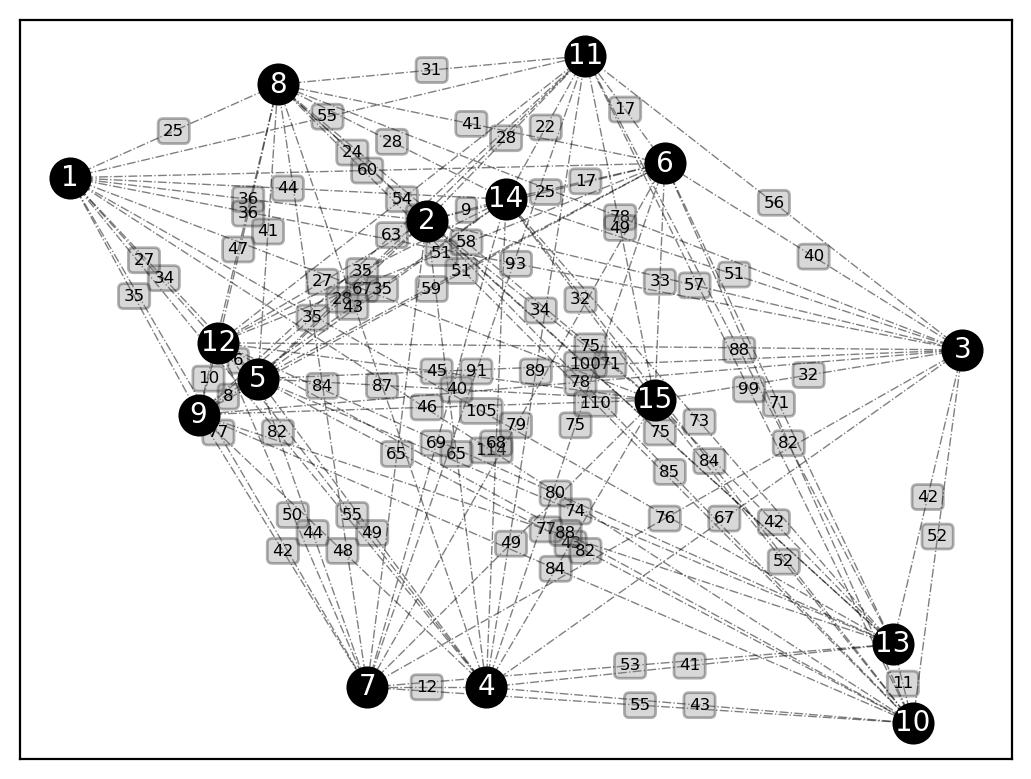

In [122]:
# ========== #
# Parameters #
# ========== #

number_of_nodes = 15

G = Graph( number_of_nodes=number_of_nodes, x_bounds=[ 0, 100 ], y_bounds=[ 0, 100 ], precision=0 )
G.generate_nodes( random_seed=7, diagonal_value=np.inf )
G.display_graph( edge_offset=5, show_weights=True )

[0, 11, 4, 8, 6, 3, 12, 9, 2, 14, 13, 10, 5, 1, 7, 0]
[0, 8, 14, 5, 10, 11, 13, 7, 3, 6, 12, 9, 2, 4, 1, 0]


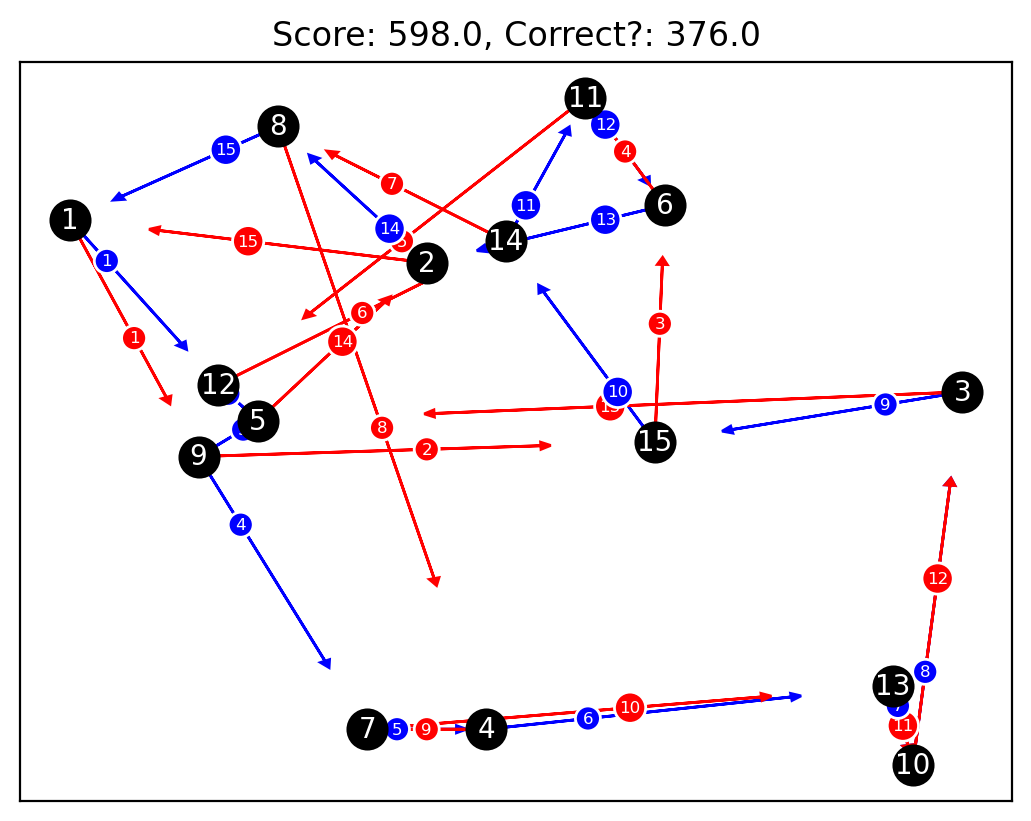

In [123]:

problem = PathProblem( G )
algorithm = GA( pop_size=100,
                sampling=IntegerRandomSampling(),
                crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
                mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
                eliminate_duplicates=True,
            )


res = minimize( problem,
                algorithm,
                termination=('n_gen', 200),
                save_history=True,
                verbose=False
              )

G.set_connectivity( connection_order=res.X )
G.set_score( score=res.F[0] )
print( list(np.concatenate(([0], res.X, [0]), axis=0) ))
G.display_graph( edge_offset=5, show_weights=False, show_edges=False, show_correct=True )